## This notebook is for visualising grids

In [2]:
# All imports should be in first cell
import netCDF4
import numpy as np
from mpl_toolkits.basemap import Basemap
import cartopy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#utility function to plot grids
PI_180 = np.pi/180.
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r', newfig=True, title=None):
    import matplotlib.pyplot as plt
#    import seaborn as sns; sns.set()
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    if(newfig):
        plt.figure(figsize=(10,10))
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
    if title is not None:
        plt.title(title)
#    plt.show()

def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r', lowerlat=None, upperlat=None, newfig=True, title=None):
    if lowerlat is not None:
        lam,phi = cut_below(lam,phi,lowerlat=lowerlat)
    if upperlat is not None:
        lam,phi = cut_above(lam,phi,upperlat=upperlat)
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color, newfig=newfig, title=title)

def cut_below(lam,phi,lowerlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>lowerlat):
            break
    jmin=j
#    print("jmin",jmin)
    return lam[jmin:,:], phi[jmin:,:]

def cut_above(lam,phi,upperlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>upperlat):
            break
    jmax=j
#    print("jmax",jmax)
    return lam[0:jmax,:], phi[0:jmax,:]

def mesh_plot(lon,lat, lon0=0.,lat0=90.,color='k',ax=None):
    """Plot a given mesh with a perspective centered at (lon0,lat0)"""
    #
    if(ax is None):
        plt.figure(figsize=(8,8))
        ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lon0, central_latitude=lat0))
        ax.set_global()
        ax.stock_img()
        ax.coastlines()
        ax.gridlines()
    (nj,ni) = lon.shape 
    for i in range(0,ni+1,2):
        ax.plot(lon[:,i], lat[:,i], color, transform=cartopy.crs.Geodetic())
    for j in range(0,nj+1,2):
        ax.plot(lon[j,:], lat[j,:], color, transform=cartopy.crs.Geodetic())
    return ax



## Read the target grid

In [4]:
def read_cs_mesh(pathname,pole=None):
    #Read in target grid
    targ_lon_tile=[]
    targ_lat_tile=[]
    for tile in range(1,7):
        targ_grid =  netCDF4.Dataset(pathname+str(tile)+'.nc')
        targ_lon=np.array(targ_grid.variables['x'])
        targ_lat=np.array(targ_grid.variables['y'])
        if(tile==4 or tile==5 or tile==6):
            targ_lon=np.transpose(targ_lon)
            targ_lat=np.transpose(targ_lat)
        print("Tile"+str(tile))
        print(" Target mesh shape: ",targ_lon.shape)
        print(" Target mesh corner ll: ",targ_lon[0,0],targ_lat[0,0])
        print(" Target mesh corner ur: ",targ_lon[-1,-1],targ_lat[-1,-1])

        if(tile==1 and not np.all(np.diff(targ_lon[0,:])>0)):
            print("   Longitude array is not monotonic. Shifting to make it so...")
            #Niki: come up with a better scheme to remove 60
            targ_lon = np.where(targ_lon>60 , targ_lon-360, targ_lon)
        if(not np.all(np.diff(targ_lon[0,:])>0)):
            print(" Error: Longitude array is still not monotonic!")

        targ_lon_tile.append(targ_lon)
        targ_lat_tile.append(targ_lat)
            
        lond=targ_lon[0,0]
        latd=targ_lat[0,0]
        lonu=targ_lon[0,-1]
        latu=targ_lat[-1,0]
        lonc=0.5*(lond+lonu)
        latc=0.5*(latd+latu)
        if((targ_lat[1,1]-targ_lat[0,0])*(targ_lat[-1,-1]-targ_lat[-2,-2]) < 0):
            if((targ_lat[1,1]-targ_lat[0,0]) < 0):
                print("Has South pole, tile ",tile)
                latc=-90.
            else:
                print("Has North pole, tile ",tile)
                latc=90.  
                if(pole is "North"):
                    return targ_lon,targ_lat,lonc,latc

    return targ_lon_tile,targ_lat_tile

 

In [5]:
pathname='/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_025/preprocessing.20201028/mosaic_c256r25tlat32.0_om4p25/'
o_grid =  netCDF4.Dataset(pathname + 'ocean_hgrid.nc')
o_lon=np.array(o_grid.variables['x'])
o_lat=np.array(o_grid.variables['y'])
o_lon.shape

(2161, 2881)

In [6]:
pathname='/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_025/preprocessing.20201028/mosaic_c256r25tlat32.0_om4p25/'          
cs32_lon_north,cs32_lat_north,lonc,latc=read_cs_mesh(pathname + 'C256_grid.tile',
                                                 pole="North")

Tile1
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  279.249274247122 14.372958013338996
 Target mesh corner ur:  212.51598193890473 -26.525639822630318
   Longitude array is not monotonic. Shifting to make it so...
 Error: Longitude array is still not monotonic!
Has South pole, tile  1
Tile2
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  245.55072575287795 14.372958013338993
 Target mesh corner ur:  160.14112471304702 45.55640082439432
 Error: Longitude array is still not monotonic!
Tile3
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  212.51598193890473 -26.525639822630318
 Target mesh corner ur:  4.65887528695287 45.55640082439433
 Error: Longitude array is still not monotonic!
Has South pole, tile  3
Tile4
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  160.14112471304702 45.55640082439432
 Target mesh corner ur:  286.4377886377425 46.424534201221896
 Error: Longitude array is still not monotonic!
Has North pole, tile  4


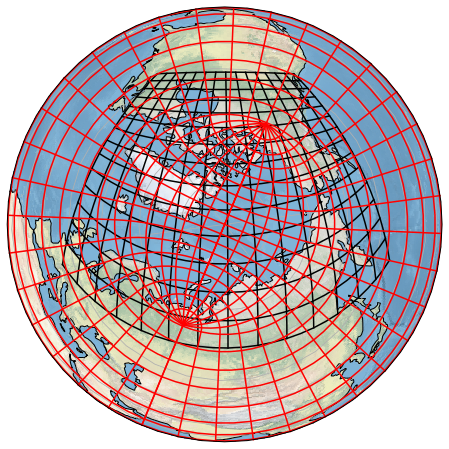

In [7]:
ax=mesh_plot(cs32_lon_north[::18,::18],cs32_lat_north[::18,::18],lon0=lonc,lat0=latc)
mesh_plot(o_lon[::40,::40],o_lat[::40,::40],color='r',ax=ax)

Tile1
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  279.5342446346188 17.624628646629223
 Target mesh corner ur:  213.74069724519066 -24.306729970589995
   Longitude array is not monotonic. Shifting to make it so...
 Error: Longitude array is still not monotonic!
Has South pole, tile  1
Tile2
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  245.26575536538115 17.624628646629223
 Target mesh corner ur:  156.82250901673535 44.73800877457723
 Error: Longitude array is still not monotonic!
Tile3
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  213.74069724519066 -24.306729970589995
 Target mesh corner ur:  7.977490983264572 44.738008774577246
 Error: Longitude array is still not monotonic!
Has South pole, tile  3
Tile4
 Target mesh shape:  (513, 513)
 Target mesh corner ll:  156.82250901673535 44.73800877457723
 Target mesh corner ur:  288.0221819094943 49.5106853517296
 Error: Longitude array is still not monotonic!
Has North pole, tile  4


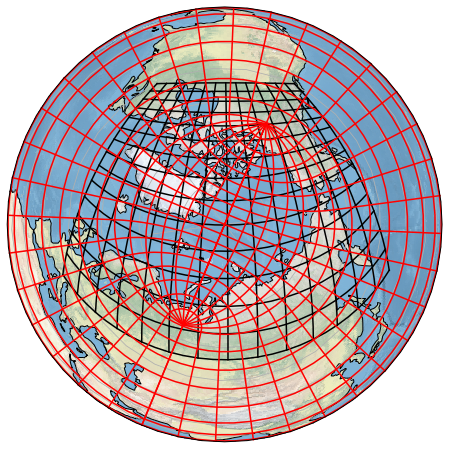

In [8]:
pathname='/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_025/preprocessing.20201028/mosaic_c256r25tlat35.4_om4p25/'          
cs35_lon_north,cs35_lat_north,lonc,latc=read_cs_mesh(pathname + 'C256_grid.tile',
                                                 pole="North")
ax=mesh_plot(cs35_lon_north[::18,::18],cs35_lat_north[::18,::18],lon0=lonc,lat0=latc)
mesh_plot(o_lon[::40,::40],o_lat[::40,::40],color='r',ax=ax)

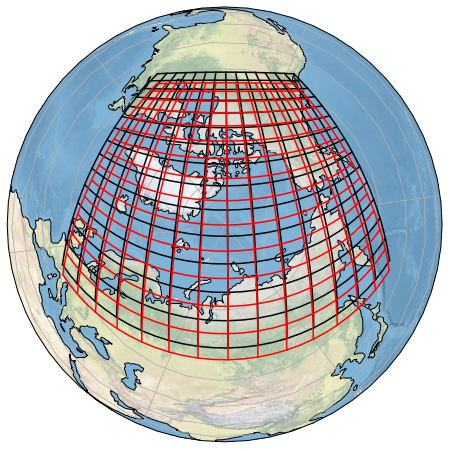

In [9]:
ax=mesh_plot(cs32_lon_north[::18,::18],cs32_lat_north[::18,::18],lon0=lonc,lat0=latc)
ax=mesh_plot(cs35_lon_north[::18,::18],cs35_lat_north[::18,::18],lon0=lonc,lat0=latc,color='r',ax=ax)
